# Note for model version
- fcn_ver_4.1.pth: train on the even frames of cam3_20230907_133530
- fcn_ver_4.2.pth: train on the even and odd frames of cam3_20230907_133530
- fcn_ver_5.pth: train on the even frames of cam4_20230907_133530
- fcn_ver_5.1.pth: train on the even frames of cam4_20230907_133530 and cam3
- fcn_ver_5.2.pth: 5.1 version carshed due to lack of money, continue training.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import io
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
import os
torch.manual_seed(0)

## Model

In [3]:
class FCN(nn.Module):
    '''
    # SegNet
    Full convolutional network Class
    Values:
        im_chan: the number of channels of the input image, a scalar
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(FCN, self).__init__()
        self.fcn = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4),
            self.make_disc_block(hidden_dim * 4, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding = 1, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Sigmoid()
            )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2,padding = 1, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                 nn.Sigmoid()
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.fcn(image)

In [4]:
criterion = nn.BCELoss()
display_step = 70
batch_size = 2
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

In [5]:
model_fcn = FCN().to(device)
model_fcn_opt = torch.optim.Adam(model_fcn.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
model_fcn = model_fcn.apply(weights_init)

In [6]:
def apply_canny_edge_detection(image):
    # Convert the PyTorch tensor image to a NumPy array
    image_np = image.permute(1, 2, 0).numpy()
    # Convert the image to grayscale
    if image_np.shape[2] != 1:
      gray_image = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    # gray_image = cv2.Canny(gray_image, threshold1=100, threshold2=120)
    # Convert the NumPy array back to a PyTorch tensor
      edged_image = torch.from_numpy(gray_image).unsqueeze(0)  # Keep it as a single-channel image

      return edged_image
    return image

In [11]:
data_root = '/content/drive/MyDrive/Colab_Notebooks/Project_CV/data/mod10'
# mod2
image_folder = os.path.join(data_root, 'cam4_20230907_133530')
mask_folder = os.path.join(data_root, 'mask_cam4_20230907_133530')

class CustomSemanticSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, mask_folder=None, transform=None, odd = False, flip = False):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.images = os.listdir(image_folder)
        self.odd = odd
        self.flip = flip
        if self.mask_folder != None:
          self.masks = os.listdir(mask_folder)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        if self.mask_folder == None:
            #index = index*2 + self.odd
            index = index*10
            test_path = os.path.join(self.image_folder, f'{index}.jpg')
            image = io.read_image(test_path)
            return image
        elif self.mask_folder != None:
            image_path = os.path.join(self.image_folder, f'image{index*2}')
            mask_path = os.path.join(self.mask_folder, f'mask{index*2}')
            if not os.path.exists(image_path + '.jpg'):
              image_path = image_path + '.png'
            elif os.path.exists(image_path + '.jpg'):
              image_path = image_path + '.jpg'
            if not os.path.exists(mask_path + '.jpg'):
              mask_path = mask_path + '.png'
            elif os.path.exists(mask_path + '.jpg'):
              mask_path = mask_path + '.jpg'
            image = io.read_image(image_path)
            mask = io.read_image(mask_path)
            if self.flip:
              image = image.flip(-1)
              mask = mask.flip(-1)
            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)

            return image, mask

## Training

In [ ]:
custom_dataset = CustomSemanticSegmentationDataset(image_folder, mask_folder, transform=None, flip = True)

edged_dataset = []

for i in tqdm(range(len(custom_dataset))):
    image, mask = custom_dataset[i]
    edged_image = apply_canny_edge_detection(image)
    edged_image = edged_image.float()
    mask = apply_canny_edge_detection(mask)
    mask = mask.float()
    resize = transforms.Resize((1456, 768))
    resized_edged_image = resize(edged_image)
    mask = resize(mask)  # Resize the mask to match the edged_image

    # Normalize the pixel values for a single channel image
    normalize = transforms.Normalize((0.5,), (0.5,))
    edged_image = normalize(resized_edged_image)
    normalize = transforms.Normalize((0,), (255,))
    mask = normalize(mask)
    edged_dataset.append((edged_image, mask))

  0%|          | 0/374 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
image_folder = os.path.join(data_root, 'mod2_cam3_20230907_133530_image')
mask_folder = os.path.join(data_root, 'labeled_mod2_cam3_20230907_133530_image')
custom_dataset = CustomSemanticSegmentationDataset(image_folder, mask_folder, transform=None, flip = False)
for i in tqdm(range(len(custom_dataset))):
    image, mask = custom_dataset[i]
    edged_image = apply_canny_edge_detection(image)
    edged_image = edged_image.float()
    mask = apply_canny_edge_detection(mask)
    mask = mask.float()
    resize = transforms.Resize((1456, 768))
    resized_edged_image = resize(edged_image)
    mask = resize(mask)  # Resize the mask to match the edged_image

    # Normalize the pixel values for a single channel image
    normalize = transforms.Normalize((0.5,), (0.5,))
    edged_image = normalize(resized_edged_image)
    normalize = transforms.Normalize((0,), (255,))
    mask = normalize(mask)
    edged_dataset.append((edged_image, mask))
# edged_dataloader = torch.utils.data.DataLoader(edged_dataset, batch_size=batch_size)
# print("Done loading data")

  0%|          | 0/372 [00:00<?, ?it/s]

In [ ]:
edged_dataloader = torch.utils.data.DataLoader(edged_dataset, batch_size=batch_size)
print("Done loading data")

Done loading data


In [ ]:
from torchsummary import summary
summary(model_fcn, (1, 1456, 768))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 728, 384]           1,024
       BatchNorm2d-2         [-1, 64, 728, 384]             128
         LeakyReLU-3         [-1, 64, 728, 384]               0
            Conv2d-4        [-1, 128, 364, 192]         131,072
       BatchNorm2d-5        [-1, 128, 364, 192]             256
         LeakyReLU-6        [-1, 128, 364, 192]               0
            Conv2d-7         [-1, 256, 182, 96]         524,288
       BatchNorm2d-8         [-1, 256, 182, 96]             512
         LeakyReLU-9         [-1, 256, 182, 96]               0
           Conv2d-10          [-1, 512, 91, 48]       2,097,152
      BatchNorm2d-11          [-1, 512, 91, 48]           1,024
        LeakyReLU-12          [-1, 512, 91, 48]               0
  ConvTranspose2d-13         [-1, 256, 182, 96]       2,097,408
      BatchNorm2d-14         [-1, 256, 

In [ ]:
def show_tensor_images(pred_mask, mask):
    pred_mask = pred_mask.detach().cpu().numpy()  # Convert predicted mask to a NumPy array on CPU
    mask = mask.detach().cpu().numpy()  # Convert ground truth mask to a NumPy array on CPU

    if pred_mask.shape != mask.shape:
        raise ValueError("The dimensions of pred_mask and mask do not match.")

    plt.figure(figsize=(8, 4))

    # Display the ground truth mask
    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(mask[0], (1, 2, 0)) * 0.5 + 0.5)  # Denormalize and transpose for display
    plt.title('Ground Truth Mask')

    # Display the predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(pred_mask[0], (1, 2, 0)) * 0.5 + 0.5)
    plt.title('Predicted Mask')

    plt.show()

In [ ]:
losses = []
with open('/content/drive/MyDrive/Colab_Notebooks/Project_CV/fcn_losses.pkl', 'rb') as file:
    losses = pickle.load(file)

In [ ]:
model_fcn.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/Project_CV/fcn_ver_5.1.pth"))

<All keys matched successfully>

  0%|          | 0/373 [00:00<?, ?it/s]

loss: %d  tensor(1.4688e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


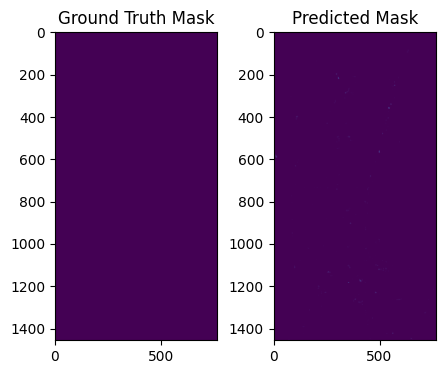

loss: %d  tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


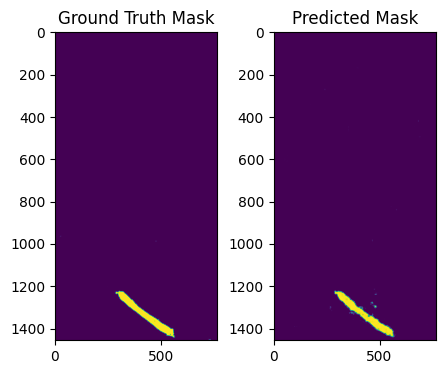

loss: %d  tensor(0.0044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


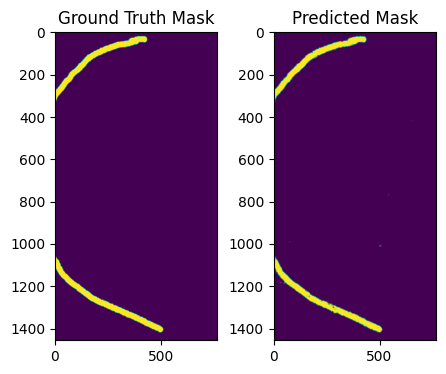

loss: %d  tensor(8.6531e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


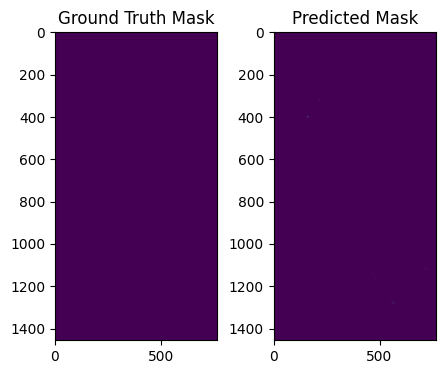

loss: %d  tensor(0.0068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


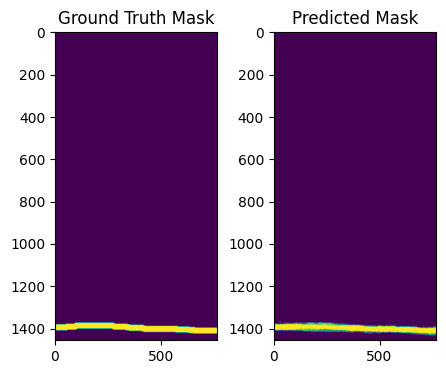

loss: %d  tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


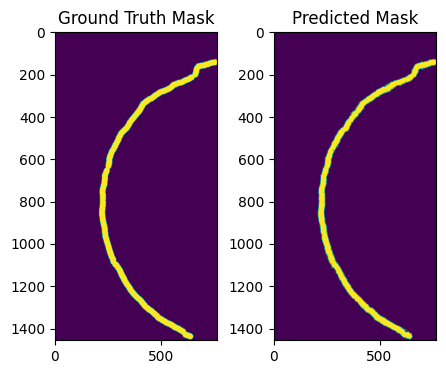

  0%|          | 0/373 [00:00<?, ?it/s]

loss: %d  tensor(7.4682e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


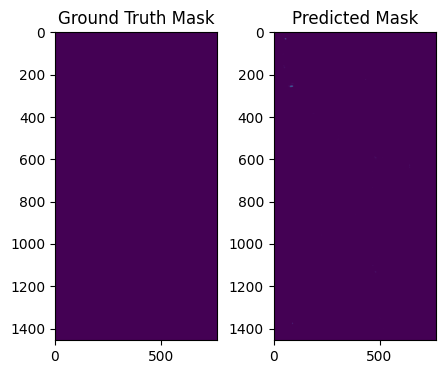

loss: %d  tensor(0.0076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


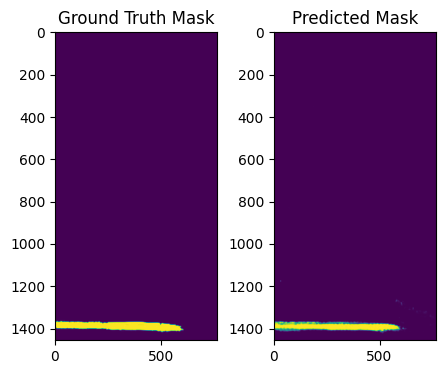

loss: %d  tensor(5.8780e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


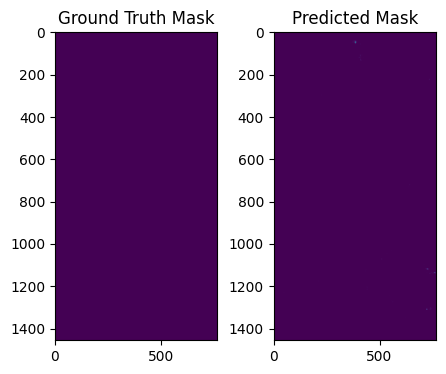

loss: %d  tensor(0.0049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


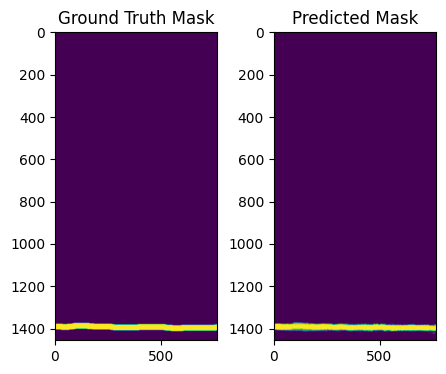

loss: %d  tensor(0.0048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


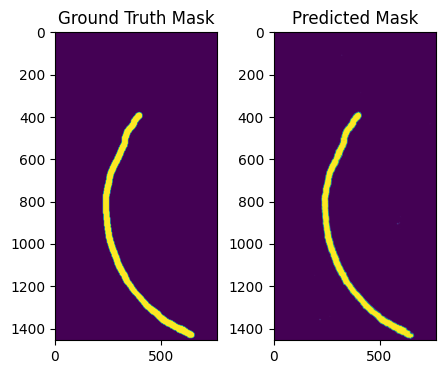

  0%|          | 0/373 [00:00<?, ?it/s]

loss: %d  tensor(7.0263e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


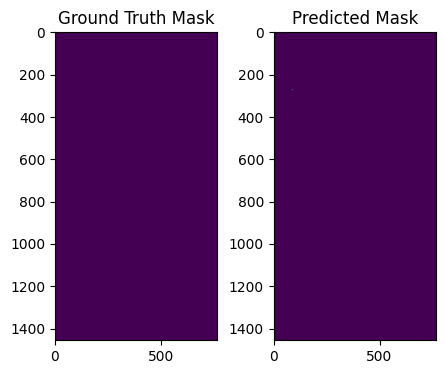

loss: %d  tensor(0.0069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


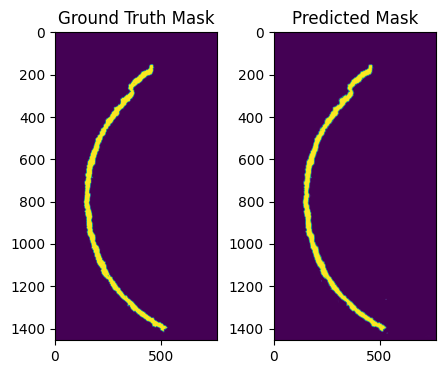

loss: %d  tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


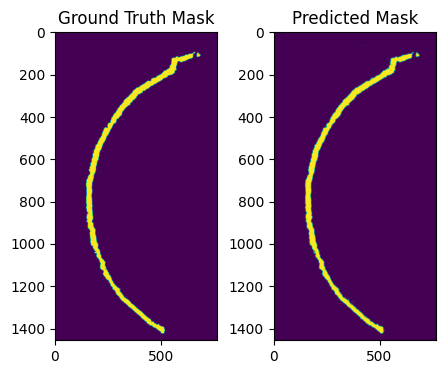

loss: %d  tensor(2.1052e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


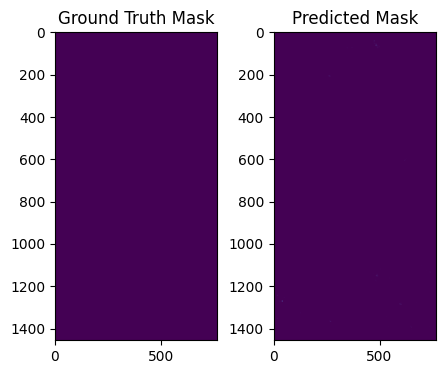

loss: %d  tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


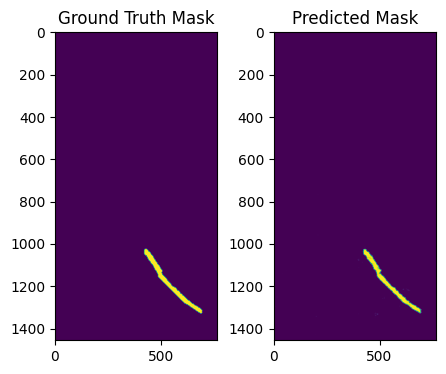

  0%|          | 0/373 [00:00<?, ?it/s]

loss: %d  tensor(1.5355e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


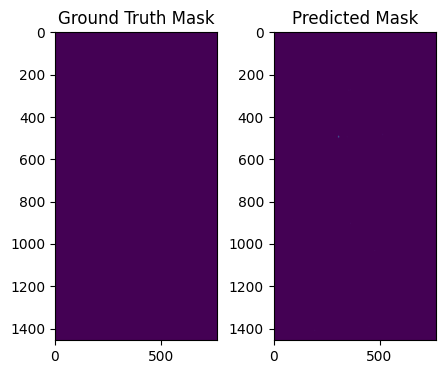

loss: %d  tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


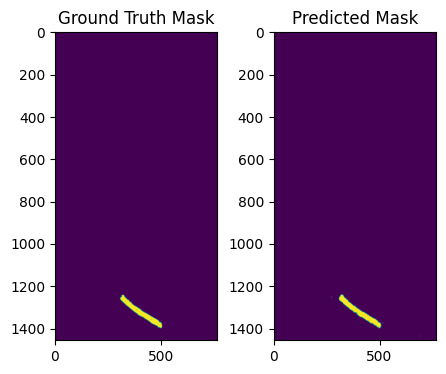

loss: %d  tensor(0.0035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


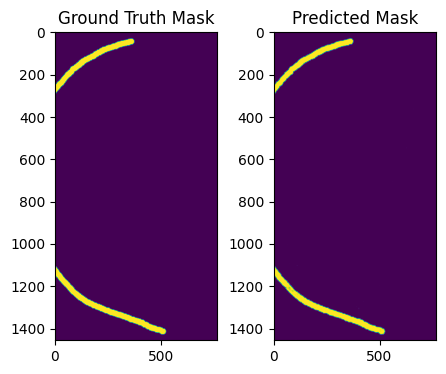

loss: %d  tensor(6.5743e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


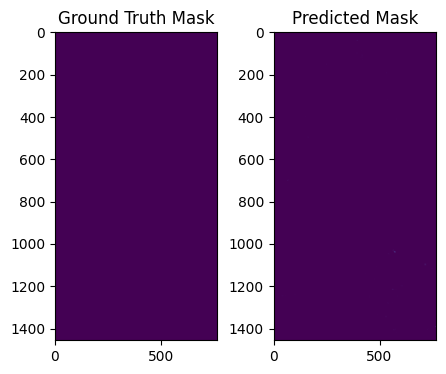

loss: %d  tensor(0.0054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


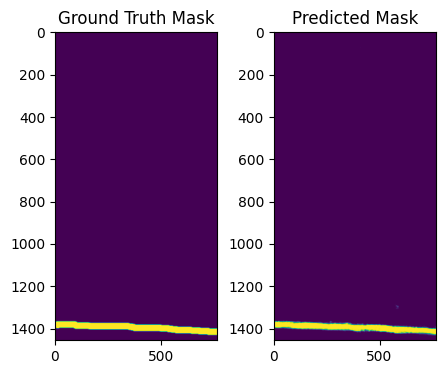

loss: %d  tensor(0.0079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


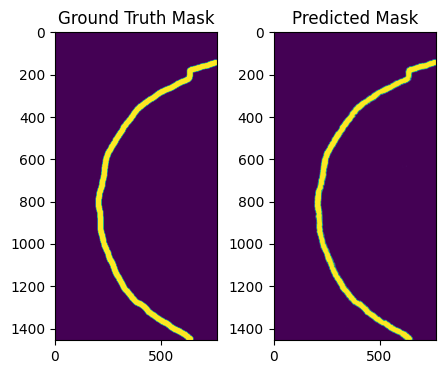

  0%|          | 0/373 [00:00<?, ?it/s]

loss: %d  tensor(5.1077e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


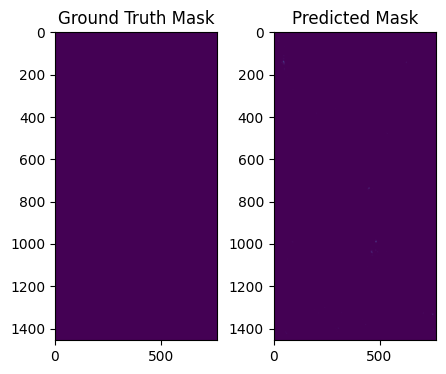

loss: %d  tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


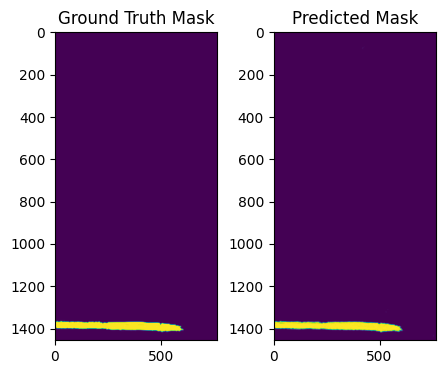

loss: %d  tensor(2.4632e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


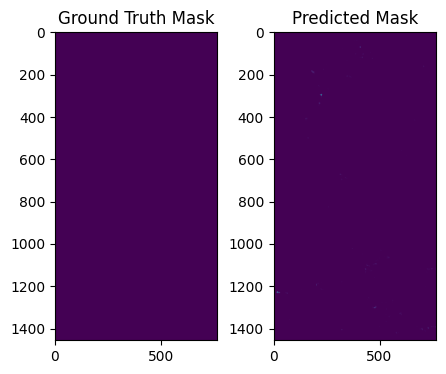

loss: %d  tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


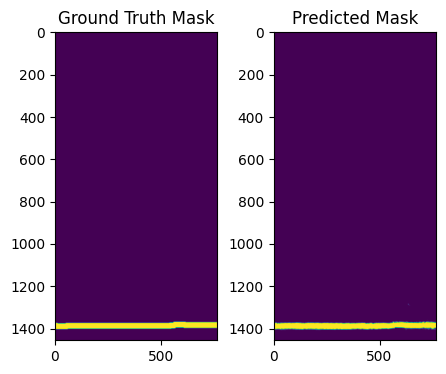

loss: %d  tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


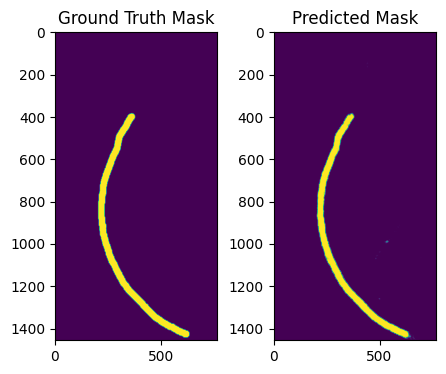

  0%|          | 0/373 [00:00<?, ?it/s]

loss: %d  tensor(3.2883e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


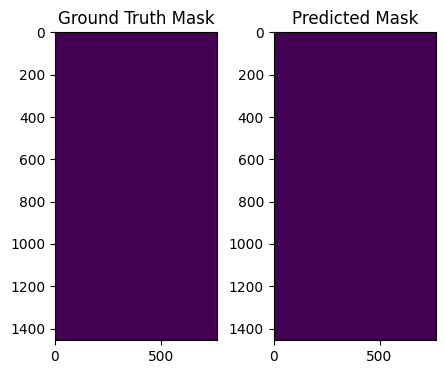

loss: %d  tensor(0.0064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


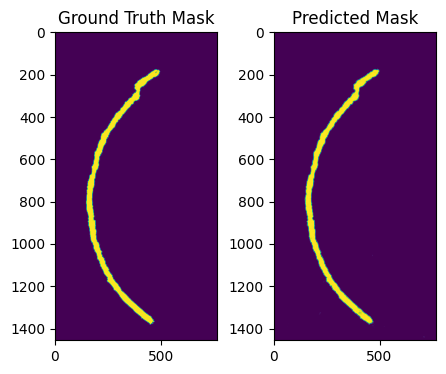

loss: %d  tensor(0.0089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


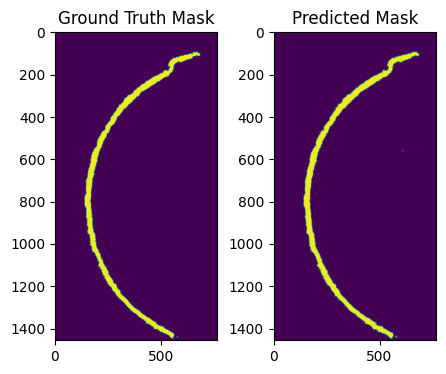

loss: %d  tensor(4.3003e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


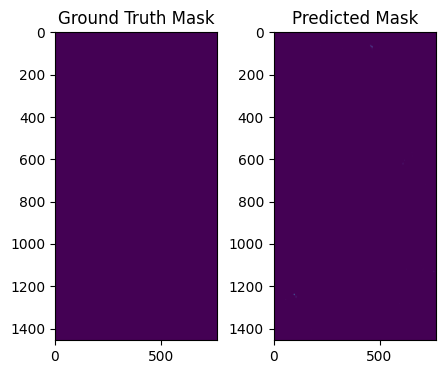

loss: %d  tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


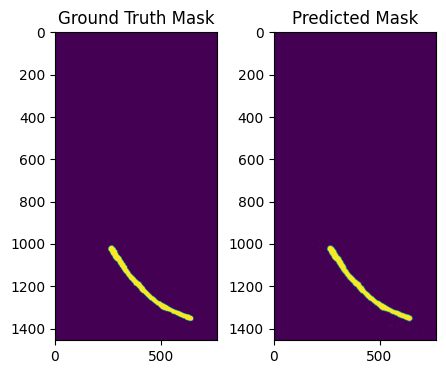

  0%|          | 0/373 [00:00<?, ?it/s]

loss: %d  tensor(1.4075e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


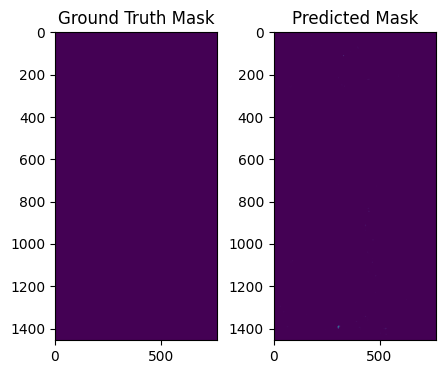

loss: %d  tensor(0.0016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


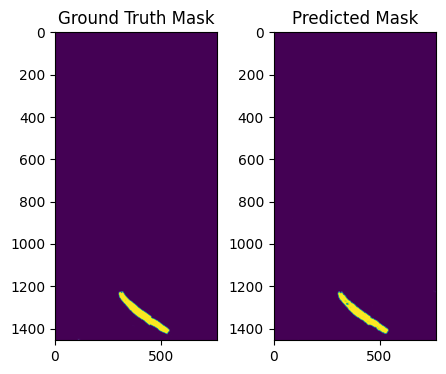

loss: %d  tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


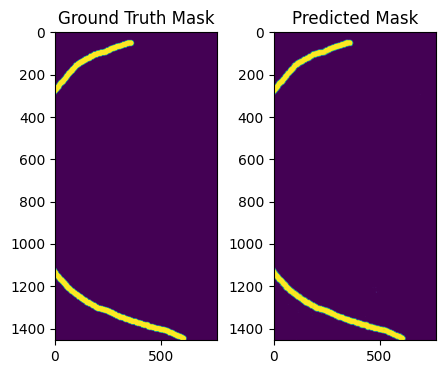

loss: %d  tensor(5.1525e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


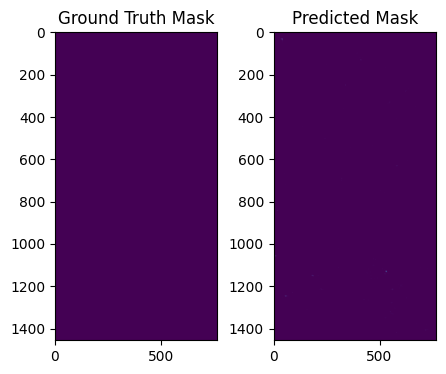

loss: %d  tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


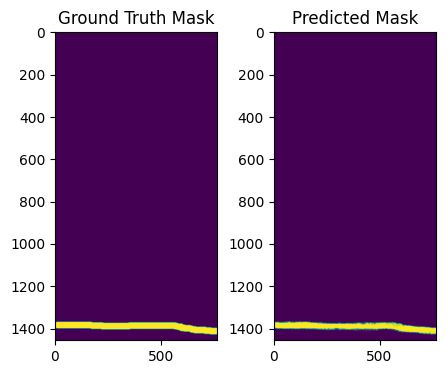

loss: %d  tensor(0.0078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


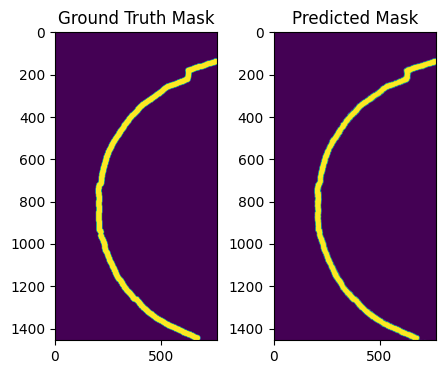

  0%|          | 0/373 [00:00<?, ?it/s]

loss: %d  tensor(4.0959e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


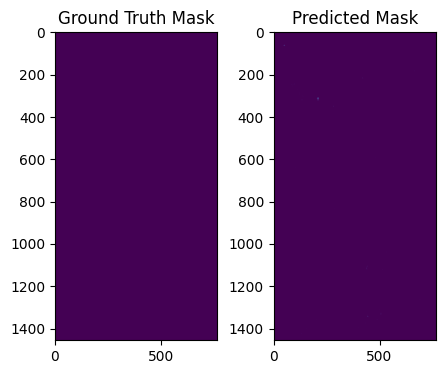

loss: %d  tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


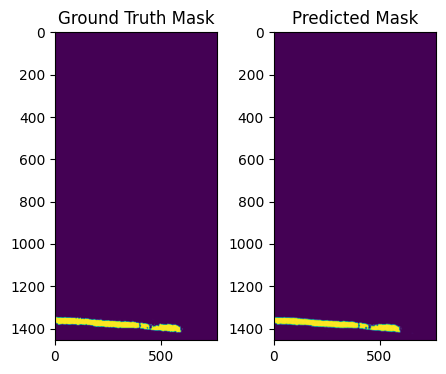

loss: %d  tensor(5.5615e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


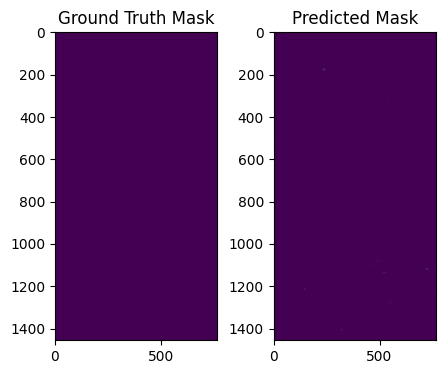

loss: %d  tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


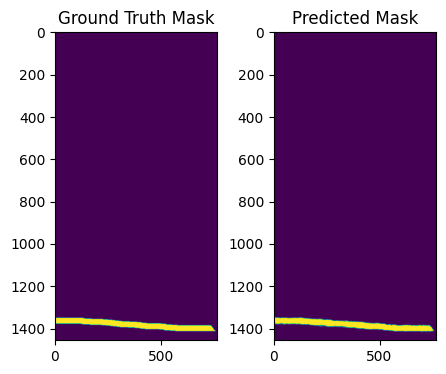

loss: %d  tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


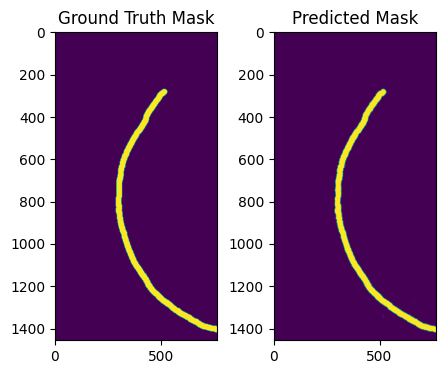

  0%|          | 0/373 [00:00<?, ?it/s]

loss: %d  tensor(2.5244e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


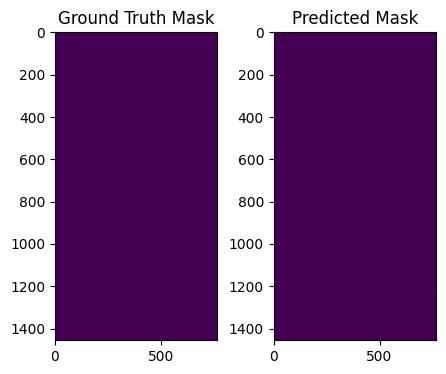

loss: %d  tensor(0.0065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


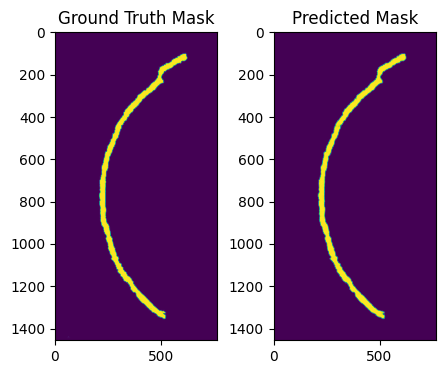

loss: %d  tensor(0.0074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


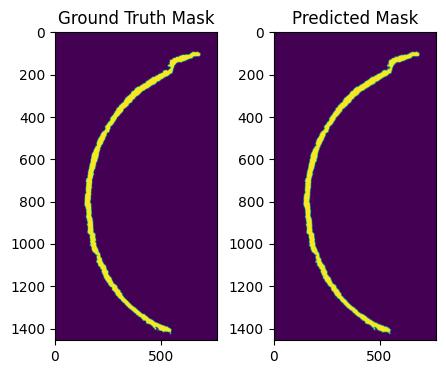

loss: %d  tensor(2.4833e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


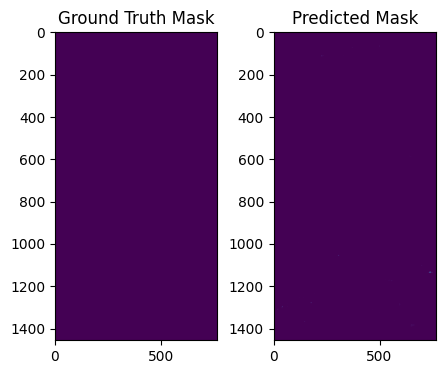

loss: %d  tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


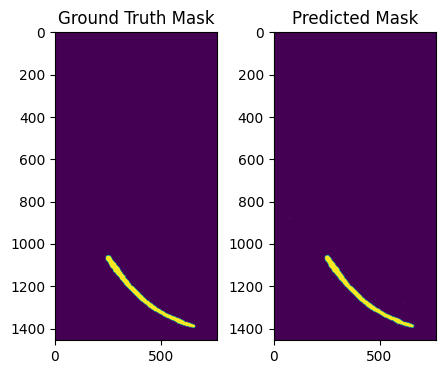

  0%|          | 0/373 [00:00<?, ?it/s]

loss: %d  tensor(1.1664e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


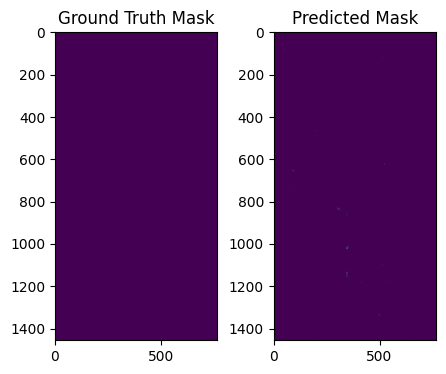

loss: %d  tensor(0.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


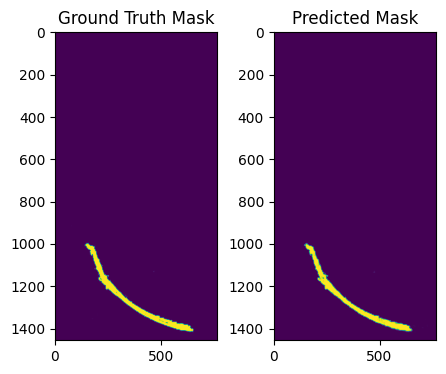

loss: %d  tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


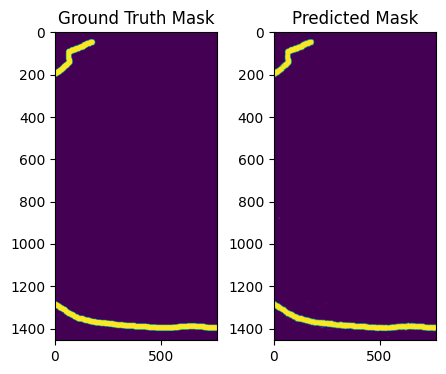

loss: %d  tensor(4.1267e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


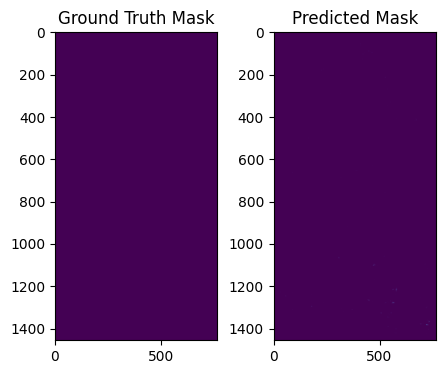

loss: %d  tensor(0.0036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


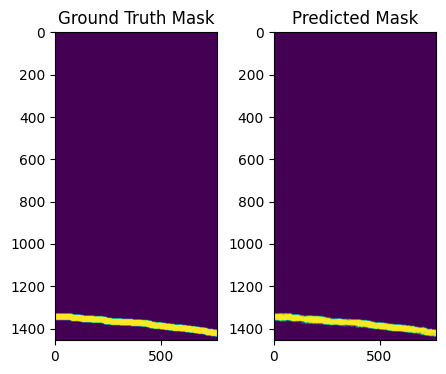

loss: %d  tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


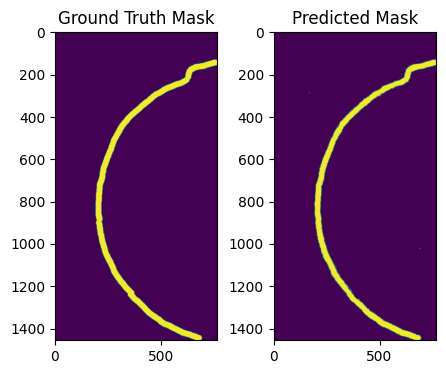

  0%|          | 0/373 [00:00<?, ?it/s]

loss: %d  tensor(1.3256e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


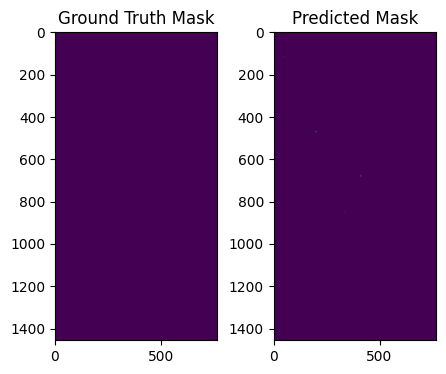

loss: %d  tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


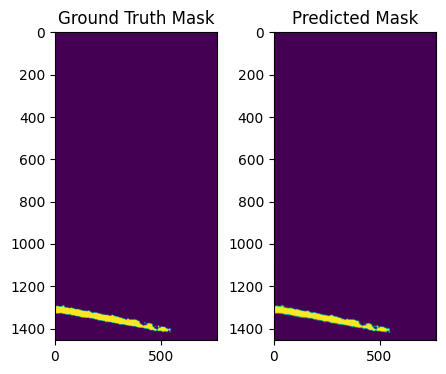

loss: %d  tensor(1.0938e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


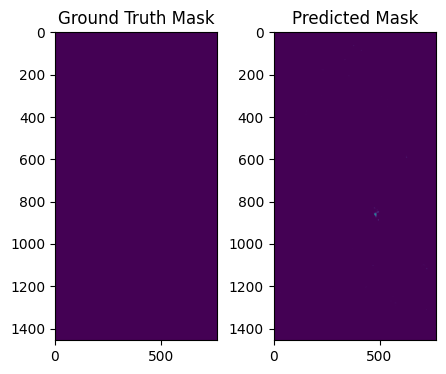

loss: %d  tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


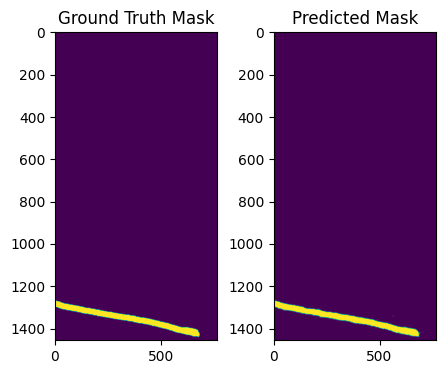

loss: %d  tensor(0.0046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


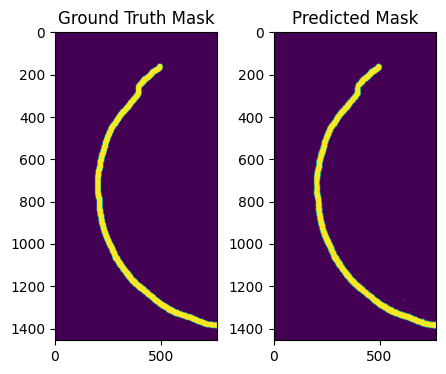

  0%|          | 0/373 [00:00<?, ?it/s]

loss: %d  tensor(3.7760e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


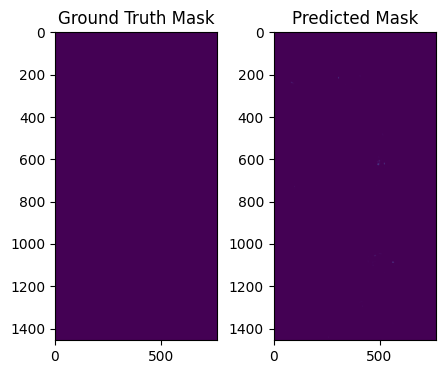

loss: %d  tensor(0.0065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


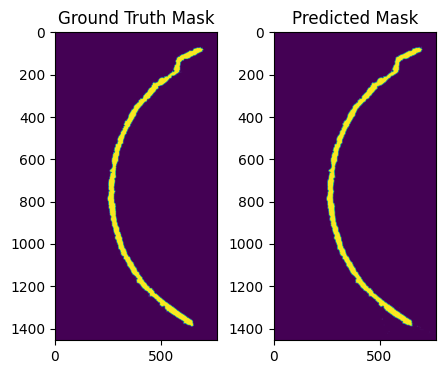

loss: %d  tensor(0.0079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


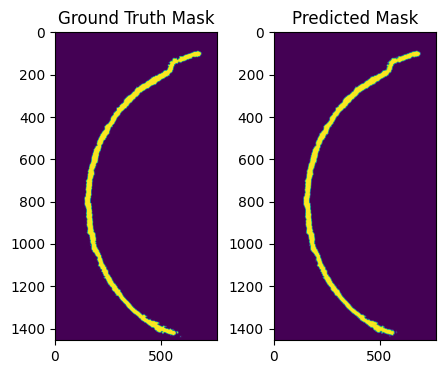

loss: %d  tensor(0.0009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


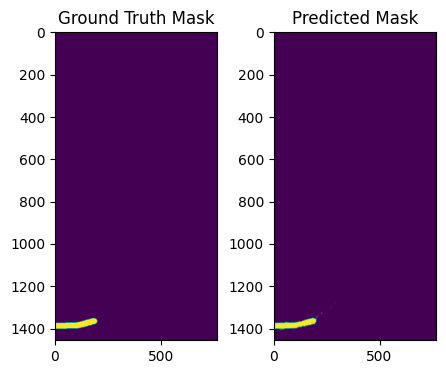

loss: %d  tensor(0.0016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


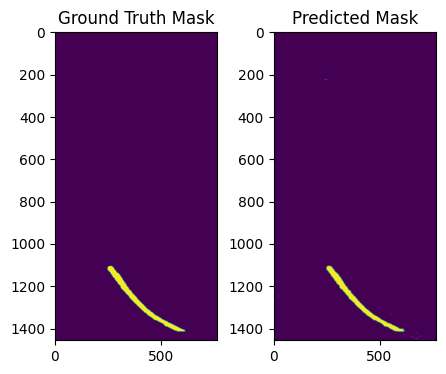

  0%|          | 0/373 [00:00<?, ?it/s]

loss: %d  tensor(3.6462e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


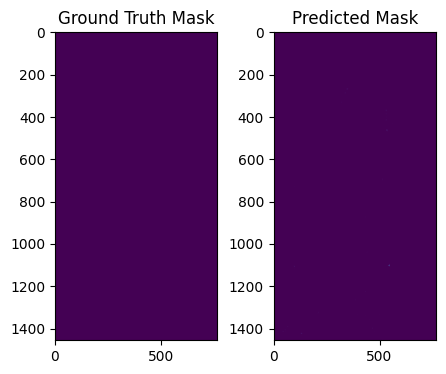

loss: %d  tensor(0.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


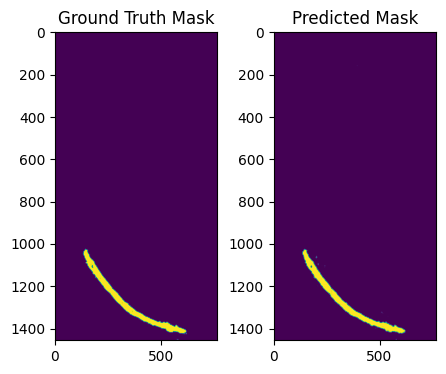

loss: %d  tensor(0.0049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


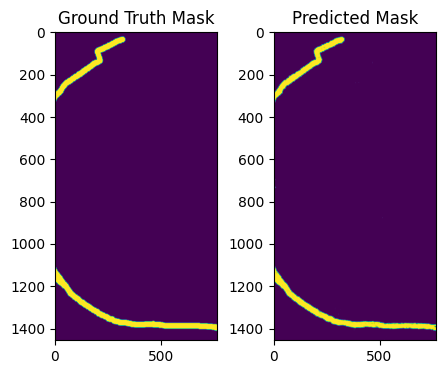

loss: %d  tensor(2.9887e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


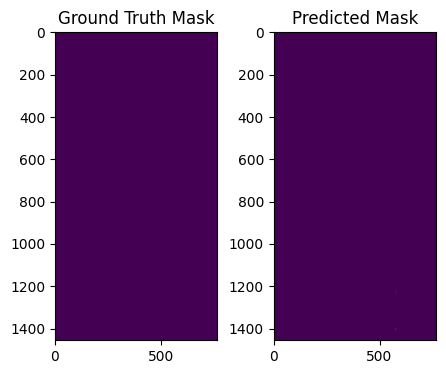

loss: %d  tensor(0.0028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


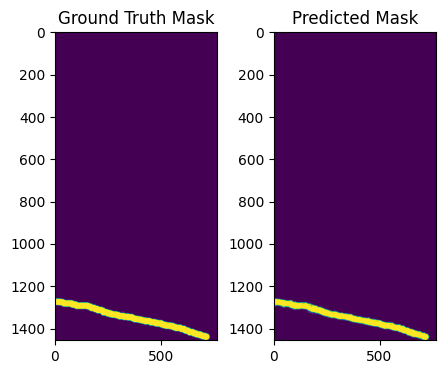

loss: %d  tensor(0.0059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


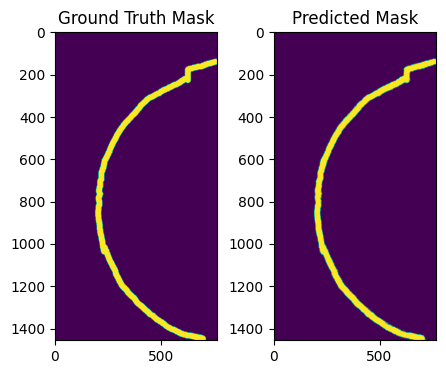

Early stopping: No improvement for 10 epochs. Stopping training.


In [ ]:
n_epochs = 600
cur_step = 0
best_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(n_epochs):
    # Dataloader returns the batches
    for image, mask  in tqdm(edged_dataloader):
        image = image.to(device)
        mask = mask.to(device)
        ## Update discriminator ##
        model_fcn_opt.zero_grad()
        pred_mask = model_fcn(image)
        loss = criterion(pred_mask, mask)

        # Update gradients
        loss.backward(retain_graph=True)
        # Update optimizer
        model_fcn_opt.step()

        # Keep track the loss to visualize.
        losses.append(loss.item())
        ## Visualization code ##
        if cur_step % display_step == 0:
              print("loss: %d ",loss)
        if cur_step % display_step*2 == 0:
              show_tensor_images(pred_mask, mask)
              with open('/content/drive/MyDrive/Colab_Notebooks/Project_CV/fcn_losses.pkl', 'wb') as file:
                pickle.dump(losses, file)
        cur_step += 1
    if loss < best_loss:
        best_loss = loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1

        # If the loss hasn't improved for 'patience' epochs, stop training
    if patience_counter >= patience:
        print(f"Early stopping: No improvement for {patience} epochs. Stopping training.")
        break
    torch.save(model_fcn.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/Project_CV/fcn_ver_5.2.pth")


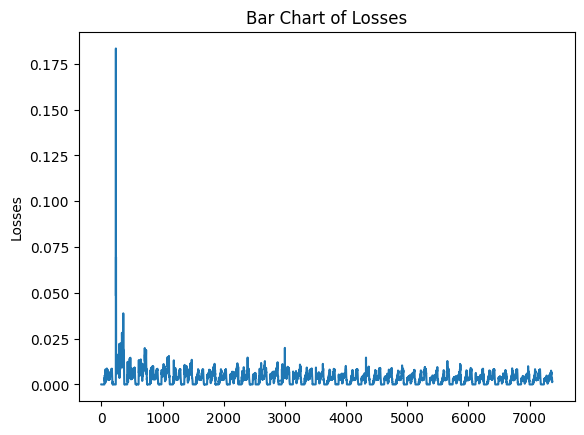

In [ ]:
plt.plot(range(len(losses)), losses)

# Set labels and
plt.ylabel('Losses')
plt.title('Bar Chart of Losses')

# Display the chart
plt.show()

## Testing
image.shape is torch.Size([3, 1447, 845])

In [8]:
# model_fcn.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/Project_CV/Nguyen/fcn_ver_5.1.pth"))
model_fcn.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/Project_CV/Nguyen/fcn_ver_5.2.pth"))

<All keys matched successfully>

### Testing for odd frame

In [12]:
image_folder = os.path.join(data_root, 'cam4_20230907_143145_mod10')
custom_testset = CustomSemanticSegmentationDataset(image_folder, mask_folder=None, transform=None, odd=False)
test_dataset = []
for i in tqdm(range(len(custom_testset))):
    test = custom_testset[i]
    edged_test = apply_canny_edge_detection(test)
    edged_test = edged_test.float()
    resize = transforms.Resize((1456, 768))
    resized_edged_test = resize(edged_test)

    # Normalize the pixel values for a single channel image
    normalize = transforms.Normalize((0.5,), (0.5,))
    edged_image = normalize(resized_edged_test)
    test_dataset.append(edged_image)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
print('Done loading test data')

  0%|          | 0/104 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Done loading test data


In [13]:
resize = transforms.Resize((1447, 845))
def visualize_predictions(model, dataloader, save_folder=None, flip = False, resize = False):
    # os.makedirs(save_folder, exist_ok=True)
    for idx, images in enumerate(dataloader):
        images = images.numpy()

        num_images = images.shape[0]

        for i in range(num_images):
            plt.figure(figsize=(8, 4))

            # Display the edged image

            plt.subplot(1, 2, 1)
            plt.imshow(np.transpose(images[i], (1, 2, 0)) * 0.5 + 0.5)  # Denormalize and transpose for display
            plt.title('Gray Image')

            # Use the model to make predictions
            with torch.no_grad():
                images_tensor = torch.from_numpy(images[i])
                images_tensor = images_tensor.unsqueeze(0).to(device)
                if flip:
                  images_tensor = images_tensor.flip(-1)
                pred_mask = model(images_tensor)
            if flip:
              pred_mask = pred_mask.flip(-1)
            # Ensure the prediction tensor has 3 channels (for RGB)
            if pred_mask.shape[1] == 1:
                # Convert single-channel prediction to 3 channels (grayscale to RGB)
                pred_mask = torch.cat([pred_mask] * 3, dim=1)
            # binary output
            pred_mask[pred_mask > 0.2] = 255
            pred_mask[pred_mask <= 0.2] = 0
            # resize to the original size
            if resize:
              pred_mask = resize(pred_mask)
            # Display the predicted mask
            plt.subplot(1, 2, 2)
            plt.imshow(np.transpose(pred_mask[0].cpu().numpy(), (1, 2, 0)))
            plt.title('Predicted Mask')

            plt.show()

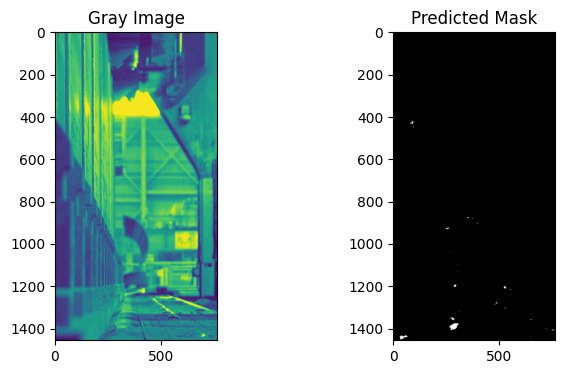

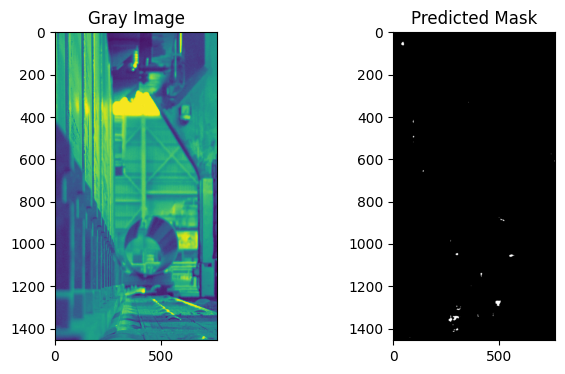

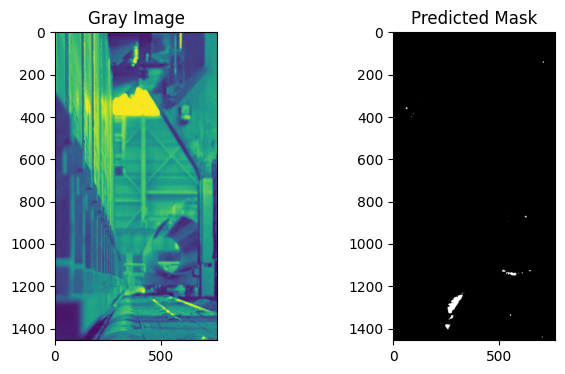

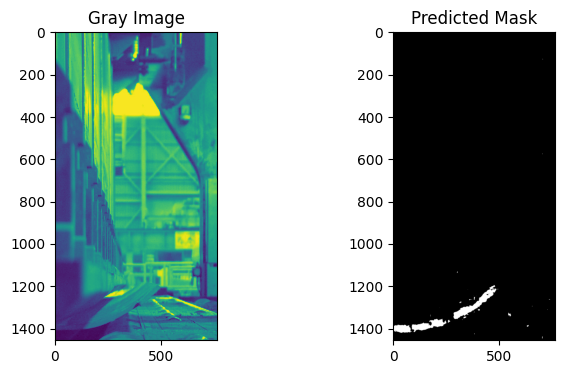

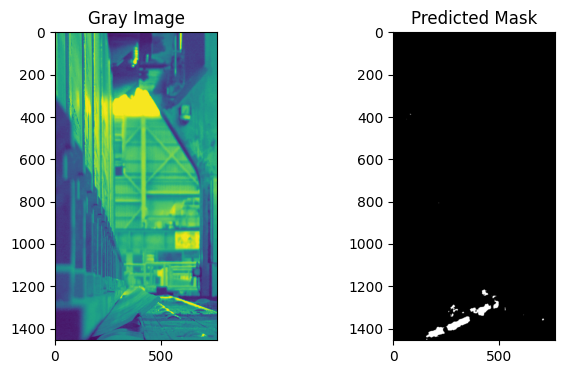

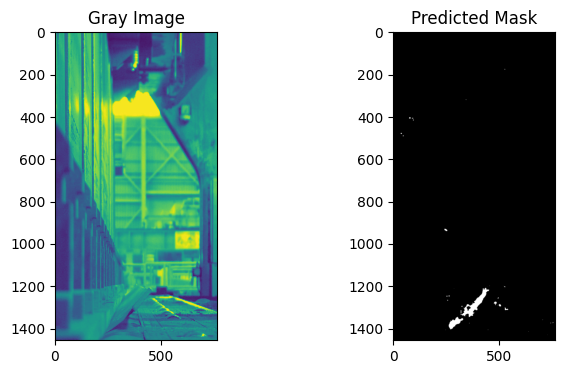

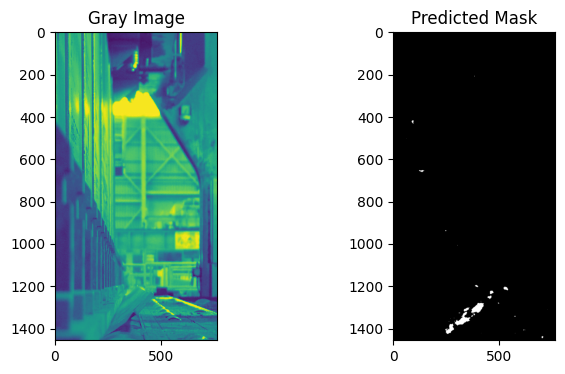

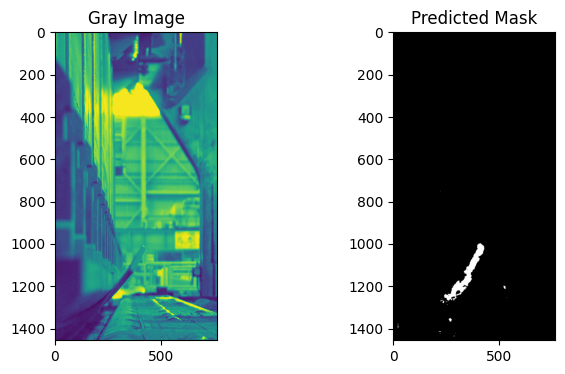

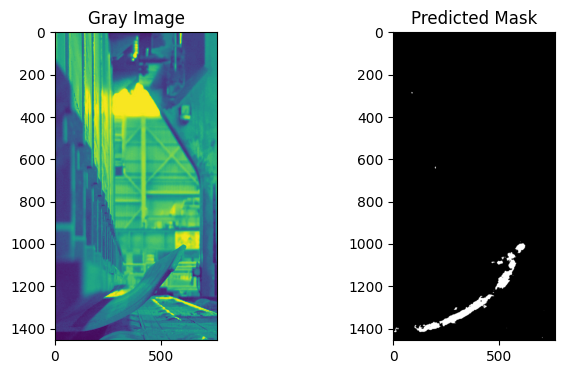

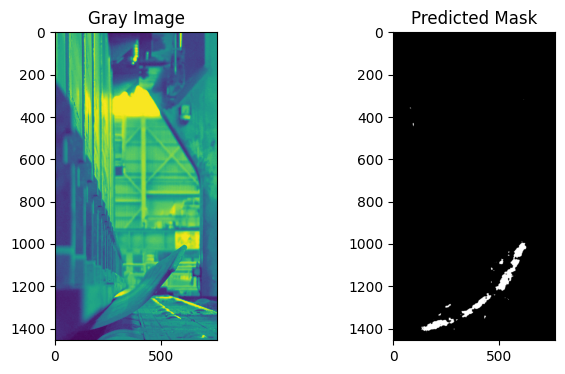

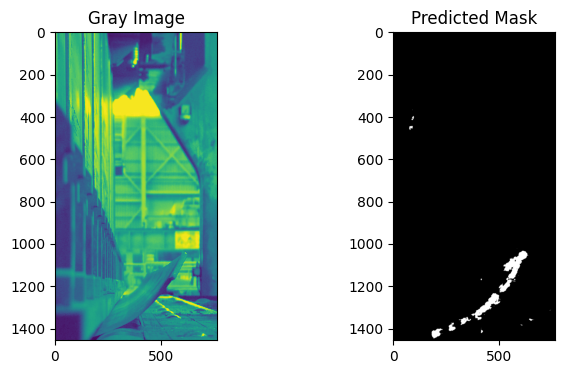

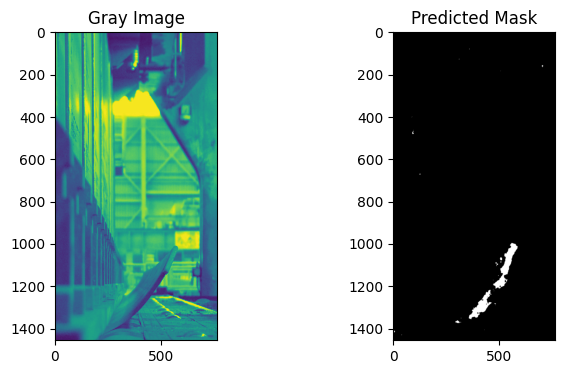

KeyboardInterrupt: ignored

In [14]:
visualize_predictions(model_fcn, test_dataloader, flip = True, resize = False)

In [16]:
def save_pred(model, dataloader, save_folder=None, flip = False, odd = False):
    for idx, images in enumerate(tqdm(dataloader)):
        images = images.numpy()
        num_images = images.shape[0]

        for i in range(num_images):
            # Use the model to make predictions
            with torch.no_grad():
                images_tensor = torch.from_numpy(images[i])
                images_tensor = images_tensor.unsqueeze(0).to(device)
                if flip:
                    images_tensor = images_tensor.flip(-1)
                pred_mask = model(images_tensor)
            if flip:
              pred_mask = pred_mask.flip(-1)
            # Ensure the prediction tensor has 3 channels (for RGB)
            if pred_mask.shape[1] == 1:
                # Convert single-channel prediction to 3 channels (grayscale to RGB)
                pred_mask = torch.cat([pred_mask] * 3, dim=1)
            pred_mask[pred_mask > 0.2] = 1
            pred_mask[pred_mask <= 0.2] = 0
            # Save the predicted mask
            if odd:
               num = (idx * num_images + i)*2 + 1
            else:
               num = (idx * num_images + i)*2
            # resize to the original size
            num = (idx * num_images + i)*10
            resize = transforms.Resize((1447, 845))
            pred_mask = resize(pred_mask)

            pred_mask_filename = os.path.join(save_folder, f'mask{num}.jpg')
            plt.imsave(pred_mask_filename, np.transpose(pred_mask[0].cpu().numpy(), (1, 2, 0)))

In [17]:
save_folder = '/content/drive/MyDrive/Colab_Notebooks/Project_CV/data/mod10/mask_cam4_20230907_143145_mod10'
save_pred(model_fcn, test_dataloader, save_folder, flip = True, odd = False)

  0%|          | 0/52 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [18]:
image_folder = os.path.join(data_root, 'cam3_20230907_143145_mod10')
custom_testset = CustomSemanticSegmentationDataset(image_folder, mask_folder=None, transform=None, odd=False)
test_dataset = []
for i in tqdm(range(len(custom_testset))):
    test = custom_testset[i]
    edged_test = apply_canny_edge_detection(test)
    edged_test = edged_test.float()
    resize = transforms.Resize((1456, 768))
    resized_edged_test = resize(edged_test)

    # Normalize the pixel values for a single channel image
    normalize = transforms.Normalize((0.5,), (0.5,))
    edged_image = normalize(resized_edged_test)
    test_dataset.append(edged_image)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
print('Done loading test data')

  0%|          | 0/103 [00:00<?, ?it/s]

Done loading test data


In [19]:
save_folder = '/content/drive/MyDrive/Colab_Notebooks/Project_CV/data/mod10/mask_cam3_20230907_143145_mod10'
save_pred(model_fcn, test_dataloader, save_folder, flip = False, odd = False)

  0%|          | 0/52 [00:00<?, ?it/s]

### Combine images

In [25]:
import os
save_folder = '/content/drive/MyDrive/Colab_Notebooks/Project_CV/data/mod10/mask_combine_cam4and3_20230907_143145_mod10'

cam3_path = '/content/drive/MyDrive/Colab_Notebooks/Project_CV/data/mod10/cam3_20230907_143145_mod10'
cam4_path = '/content/drive/MyDrive/Colab_Notebooks/Project_CV/data/mod10/cam4_20230907_143145_mod10'

mask_cam3_path = '/content/drive/MyDrive/Colab_Notebooks/Project_CV/data/mod10/mask_cam3_20230907_143145_mod10'
mask_cam4_path = '/content/drive/MyDrive/Colab_Notebooks/Project_CV/data/mod10/mask_cam4_20230907_143145_mod10'

# Get the list of files in each folder
files_cam3 = os.listdir(cam3_path)
files_cam4 = os.listdir(cam4_path)
files_cam3 = sorted(files_cam3, key=lambda x: int(x.split('.')[0]))
files_cam4 = sorted(files_cam4, key=lambda x: int(x.split('.')[0]))

mask_files_cam3 = os.listdir(mask_cam3_path)
mask_files_cam4 = os.listdir(mask_cam4_path)
mask_files_cam3 = sorted(mask_files_cam3, key=lambda x: int(x.split('.')[0][4:]))
mask_files_cam4 = sorted(mask_files_cam4, key=lambda x: int(x.split('.')[0][4:]))

# files_cam3 = files_cam3[327:]
# files_cam4 = files_cam4[310:]
# mask_files_cam3 = mask_files_cam3[327:]
# mask_files_cam4 = mask_files_cam4[310:]
# Iterate over the files in both folders
resize = transforms.Resize((1447, 845))
for img_cam3, img_cam4, mask_cam3, mask_cam4 in zip(files_cam3, files_cam4, mask_files_cam3, mask_files_cam4):

    # img_cam3_path = os.path.join(cam3_path, img_cam3)
    # img_cam4_path = os.path.join(cam4_path, img_cam4)

    maskcam3_path = os.path.join(mask_cam3_path, mask_cam3)
    maskcam4_path = os.path.join(mask_cam4_path, mask_cam4)
    # plt.figure(figsize = (10, 10))

    # image_3 = resize(io.read_image(img_cam3_path))
    # image_4 = resize(io.read_image(img_cam4_path))
    # combine = np.zeros((image_3.size()[1], image_3.size()[2]*2, 3), dtype=np.uint8)
    # combine[:, :image_3.size()[2]] = np.transpose(image_3, (1,2,0))
    # combine[:, image_3.size()[2]:image_3.size()[2]*2] = np.transpose(image_4, (1,2,0))

    mask_3 = resize(io.read_image(maskcam3_path))
    mask_4 = resize(io.read_image(maskcam4_path))
    mask_com = np.zeros((mask_3.size()[1], mask_3.size()[2]*2, 3), dtype=np.uint8)
    mask_com[:, :mask_3.size()[2]] = np.transpose(mask_3, (1,2,0))
    mask_com[:, mask_3.size()[2]:mask_3.size()[2]*2] = np.transpose(mask_4, (1,2,0))

    # result_image = np.concatenate([combine, mask_com], axis=1)

    # plt.imshow(result_image)
    combine_filename = os.path.join(save_folder, f'combine{img_cam3.split(".")[0]}.jpg')
    plt.imsave(combine_filename, mask_com)
    # plt.show()